In [13]:
import sys
!{sys.executable} -m pip install numpy matplotlib Pillow seaborn

  Using cached https://files.pythonhosted.org/packages/63/0c/0261693cc3ad8e2b66e66dc2d2676a2cc17d3efb1c58a70db73754320e47/numpy-1.18.1-cp37-cp37m-manylinux1_x86_64.whl
  Using cached https://files.pythonhosted.org/packages/61/42/3e92d7aa64295483fbca20a86c89b34d0cb43cffaadaffe028793902d790/matplotlib-3.1.2-cp37-cp37m-manylinux1_x86_64.whl
  Using cached https://files.pythonhosted.org/packages/f5/79/b2d5695d1a931474fa68b68ec93bdf08ba9acbc4d6b3b628eb6aac81d11c/Pillow-7.0.0-cp37-cp37m-manylinux1_x86_64.whl
  Using cached https://files.pythonhosted.org/packages/a8/76/220ba4420459d9c4c9c9587c6ce607bf56c25b3d3d2de62056efe482dadc/seaborn-0.9.0-py3-none-any.whl
  Using cached https://files.pythonhosted.org/packages/f7/d2/e07d3ebb2bd7af696440ce7e754c59dd546ffe1bbe732c8ab68b9c834e61/cycler-0.10.0-py2.py3-none-any.whl
  Using cached https://files.pythonhosted.org/packages/d4/70/d60450c3dd48ef87586924207ae8907090de0b306af2bce5d134d78615cb/python_dateutil-2.8.1-py2.py3-none-any.whl
  Using cached ht

In [27]:
# Constants
event = "2019cc"
team = 254
match = 100

data_root = "/home/ewpratten/projects/ZEBRA-Kinematics/"


In [28]:
filepath = data_root + f"events/{event}/Team{team}/Match{match}.csv"


# Parse dart data to a datapoint list
lines = open(filepath).read().split("\n")[2:-1]
datapoints = []
for line in lines:
    raw_data = line.split(",")
    datapoints.append((float(raw_data[0]), float(raw_data[1]), float(raw_data[2])))

# Print data metrics
print(f"Loaded Dart data for team {team} at {event} in match {match} with {len(datapoints)} datapoints")

Loaded Dart data for team 254 at 2019cc in match 100 with 1518 datapoints


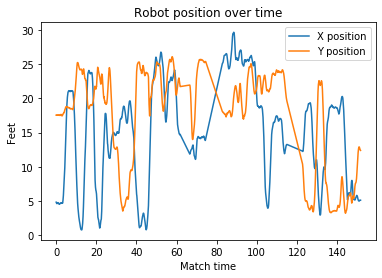

In [29]:
# Import needed graphing tools
import matplotlib.pyplot as plt

# Plot the X, Y over time
times = [p[2] - datapoints[0][2] for p in datapoints]
x_poses = [p[0] for p in datapoints]
y_poses = [p[1] for p in datapoints]

# Plot
plt.plot(times, x_poses)
plt.plot(times, y_poses)
plt.legend(["X position", "Y position"])
plt.title('Robot position over time')
plt.ylabel('Feet')
plt.xlabel('Match time')
plt.show()


In [30]:
from math import atan2

class Twist(object):
    """
    A difference in 2D space with heading
    """

    # Locals
    dx: float
    dy: float
    dTheta: float
    
    # Constants
    DEFAULT_TRACK_WIDTH: float = 25.42
    TRACK_SCRUB: float = 1.0469745223 # From 254's 2019 bot

    def __init__(self, dx: float, dy: float, dTheta: float) -> None:
        """
        Create a Twist

        :param dx:     X difference
        :param dy:     Y difference
        :param dTheta: Theta difference
        """

        # Set locals
        self.dx = dx
        self.dy = dy
        self.dTheta = dTheta

    @classmethod
    def fromTranslation(self, prevX: float, prevY: float, x: float, y: float) -> None:
        """
        Create a Twist from last and current points in space

        :param prevX: Previous X position
        :param prevY: Previous Y position
        :param x:     Current X position
        :param y:     Current Y position
        """

        # Calculate dx and dy
        dx: float = x - prevX
        dy: float = y - prevY

        # Calculate dTheta
        dTheta: float = atan2(dx, dy)

        # Create a new Twist
        return self(dx, dy, dTheta)

    def toWheelSpeeds(self) -> (float, float):
        """
        Calculate differential wheel velocities from Twist
        """
        
        # Handle tiny changes in space
        if abs(self.dTheta) < 1E-9:
            return (dx, dy)
        
        # Handle chassis kinematics
        deltaV: float = self.DEFAULT_TRACK_WIDTH * self.dTheta / (2 * self.TRACK_SCRUB)
        return (self.dx - deltaV, self.dx + deltaV)
        

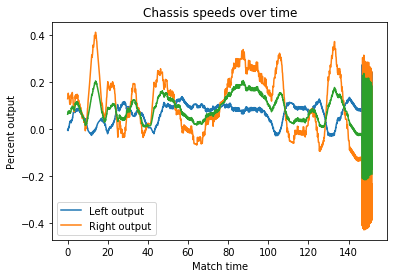

In [33]:
# Get a set of wheel speeds

last_pose = [0,0]
speeds = []
for i in range(len(x_poses)):
    twist = Twist.fromTranslation(last_pose[0], last_pose[1], x_poses[i], y_poses[i])

    wheelSpeeds: tuple = twist.toWheelSpeeds()

    speeds.append(list(wheelSpeeds))

    # Set last pose
    last_pose = [wheelSpeeds[0], wheelSpeeds[1]]

# timeSlice = 200

# speeds = speeds[timeSlice*-1:]
# times = times[timeSlice*-1:]

sample_size = 50

# Smooth out speeds
for i in range(len(speeds)):

    # Break early because I am lazy
    if i >= len(speeds) - sample_size:
        break

    # Smooth
    l = 0
    for offset in range(sample_size):
        l += speeds[i + offset][0]

    l /= sample_size

    speeds[i][0] = l

    r = 0
    for offset in range(sample_size):
        r += speeds[i + offset][1]

    r /= sample_size

    speeds[i][1] = r

    

# Plot
plt.plot(times, [s[0] / 100 for s in speeds])
plt.plot(times, [s[1] / 100 for s in speeds])
plt.plot(times, [(s[1] + s[0]) / 2 / 100 for s in speeds])
plt.legend(["Left output", "Right output"])
plt.title('Chassis speeds over time')
plt.ylabel('Percent output')
plt.xlabel('Match time')
plt.show()
